## Classifier and preprocessing

In this notebook, the noironicos dataset will be treated, since ironicos's tweets are all ironic and we want a mixture of ironic and non ironic.

In [1]:
# General import and load data
import numpy as np
import nltk
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
import re
%run plot_learning_curve.ipynb

nltk.download('punkt')
nltk.download('stopwords')
# Import database
df_noironicos=pd.read_csv('noironicos_bodies.csv')

# Encode categorical variable (ironic)
df_noironicos.loc[df_noironicos['ironic']==True, "ironic"] = 1
df_noironicos.loc[df_noironicos['ironic']==False, "ironic"] = 0

# Drop non-used columns
df_noironicos.drop(['id_tweet', 'depends_image', 'depends_link', 'depends_retweet'], axis=1, inplace=True)

# Drop nan rows
df_clean=df_noironicos.dropna(subset=['text'])
df_noironicos=df_clean

# Final dataset
df_noironicos.head()

Automatically created module for IPython interactive environment


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,ironic,text
0,1,Algunas personas sufren en las discos mientras...
3,1,@jacevedoaraya es para sostener el marcador......
4,1,Alguna de estas imágenes te sacara una sonrisa...
5,1,@_Eurovision2014 en 2013 falta esdm jajajajaja...
6,1,Hooo que buen padre...#Sarcasmo #GH2015


In [2]:
# Define X and Y
X = df_noironicos['text'].values
y = df_noironicos['ironic'].values.astype(int)

## Lexical features
The lexical features analysis will be performed by using the twitter tokenizer provided by nltk library.


In [3]:
# Sample of statistics using nltk
# Another option is defining a function and pass it as a parameter to FunctionTransformer

from sklearn.base import BaseEstimator, TransformerMixin
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import string


class LexicalStats (BaseEstimator, TransformerMixin):
       
    
    def number_sentences(self, doc):
        sentences = sent_tokenize(doc, language='spanish')
        return len(sentences)

    def fit(self, x, y=None):
        return self

    def transform(self, docs):
        return [{'length': len(doc),
                 'num_sentences': self.number_sentences(doc)}
                for doc in docs]


def custom_tokenizer(words):
    tokens = word_tokenize(words.lower())
    porter = PorterStemmer()
    lemmas = [porter.stem(t) for t in tokens]
    stoplist = stopwords.words('english')
    lemmas_clean = [w for w in lemmas if w not in stoplist]
    punctuation = set(string.punctuation)
    lemmas_punct = [w for w in lemmas_clean if  w not in punctuation]
    return lemmas_punct

## Syntactic features

## Feature extraction Pipeline
The feature extraction will be carried out by using pipelines. The defined pipelines are selected in order to extracting the desired features

In [4]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

ngrams_featurizer = Pipeline([
  ('count_vectorizer',  CountVectorizer(ngram_range = (1, 3), encoding = 'utf-8', 
                                        tokenizer=custom_tokenizer)),
  ('tfidf_transformer', TfidfTransformer())
])

## Feature Union Pipeline
Now we define which features we want to extract, how to combine them and later apple machine learning in the resulting feature set.

In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.metrics import classification_report
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation

def pipeline(clf):
    return Pipeline([
       ('features', FeatureUnion([
                    ('lexical_stats', Pipeline([
                                ('stats', LexicalStats()),
                                ('vectors', DictVectorizer())
                            ])),
                    ('words', TfidfVectorizer(tokenizer=custom_tokenizer)),
                    ('ngrams', ngrams_featurizer),
        
                    ('lda', Pipeline([ 
                                ('count', CountVectorizer(tokenizer=custom_tokenizer)),
                                ('lda',  LatentDirichletAllocation(n_topics=4, max_iter=5,
                                                       learning_method='online', 
                                                       learning_offset=50.,
                                                       random_state=0))
                            ])),
                ])),
       
        ('clf', clf)  # classifier
    ])

def classification_report_with_accuracy_score(y_true, y_pred):

    print (classification_report(y_true, y_pred)) # print classification report
    return accuracy_score(y_true, y_pred) # return accuracy score

cv = KFold(X.shape[0], n_folds=5, shuffle=False, random_state=33)

# Use KFold validation

# cv = KFold(X.shape[0], 2, shuffle=True, random_state=33)
# scores = cross_val_score(pipeline, X, y, cv=cv)
# print("Scores in every iteration", scores)
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Yo quiero hacer el confussion matrix y f score. Para ello, necesito el training y testing dataset. Eso lo puedo hacer usando el vector X, pero el vector X tiene strings (arrays de twits) y el modelo (osea mi pipeline) transforma ese array de strings en números. Esos números, son procesados y metidos en el pipeline para darme el modelo. Entonces, como quiero hacer el f1 score, necesito un training y testing dataset. Pero, paa hacer el método pipeline.predict(X_test) necesito que X_test sea números (sino salta error que ya me ha pasado). Entonces, como hago ese test split en el pipeline?

## Train Optimize and Evaluate

### MultinomialNB

In [ ]:
from sklearn.model_selection import GridSearchCV

pipelineNB = pipeline(MultinomialNB(alpha=.01))
gammas = np.logspace(-6, -1, 10)
parametersNB = {'clf__alpha': [.0001,.001,.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]}
# gs = GridSearchCV(pipelineNB, parametersNB)
# gs = gs.fit(X, y)
plot_learning_curve(gs, 'Curve', X, y, cv=cv)

/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will b

/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will b

/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will b

/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will b

/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will b

/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will b

/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will b

/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will b

/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will b

/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will b

/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will b

In [7]:
print("Best Score with MultinomialNB: %s" % gs.best_score_)
for param_name in sorted(parametersNB.keys()):
    print("%s: %r" % (param_name, gs.best_params_[param_name]))

Best Score with MultinomialNB: 0.931126644737
clf__alpha: 0.1


In [8]:
from sklearn.cross_validation import cross_val_score, KFold 
#Evaluate with K-Fold
model_NB = pipeline(MultinomialNB(alpha=gs.best_params_['clf__alpha'] ))
scores = cross_val_score(model_NB, X, y, cv=cv)
print("Scores in every iteration", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will b

Scores in every iteration [ 0.92600206  0.93216855  0.92189106  0.94244604  0.93312757]
Accuracy: 0.93 (+/- 0.01)


/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will b

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

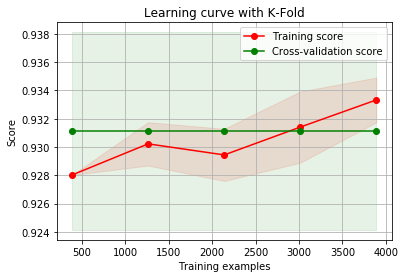

In [9]:
 plot_learning_curve(model_NB, "Learning curve with K-Fold", X, y, cv=cv)

In [10]:
# Nested CV with parameter optimization
nested_score = cross_val_score(model_NB, X, y, cv=cv, \
               scoring=make_scorer(classification_report_with_accuracy_score))
print (nested_score)

NameError: name 'make_scorer' is not defined

## SVC

In [14]:
# Estimators
from sklearn.svm import SVC

model_SVC = pipeline(SVC(kernel = 'linear', C=1))
cv_SVC = cross_val_score(model_SVC, X,y,cv=cv)

#plot_learning_curve(model_SVC, 'optimized with GridSearch', X,y, cv=cv)

KeyboardInterrupt: 

In [18]:
cv_SVC=scores